# Visualization
Key Visuals:
- Overview Map
- Animation

## Import Shapefile

In [14]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

shapefile_path = "data/spatial/geo_export_86dc231e-3ba9-473c-a7a5-0e89f969d1f6.shp"
gdf = gpd.read_file(shapefile_path)

# convert to 2790
gdf = gdf.to_crs('EPSG:2790')

# compute new square foot areas
gdf['area_2790'] = gdf['geometry'].area

# drop old spatial columns
gdf = gdf.drop(columns = ["shape_area", "shape_len"])

df = pd.read_csv('./data/results/processed/semi_hourly_28th.csv')

## Overview Map

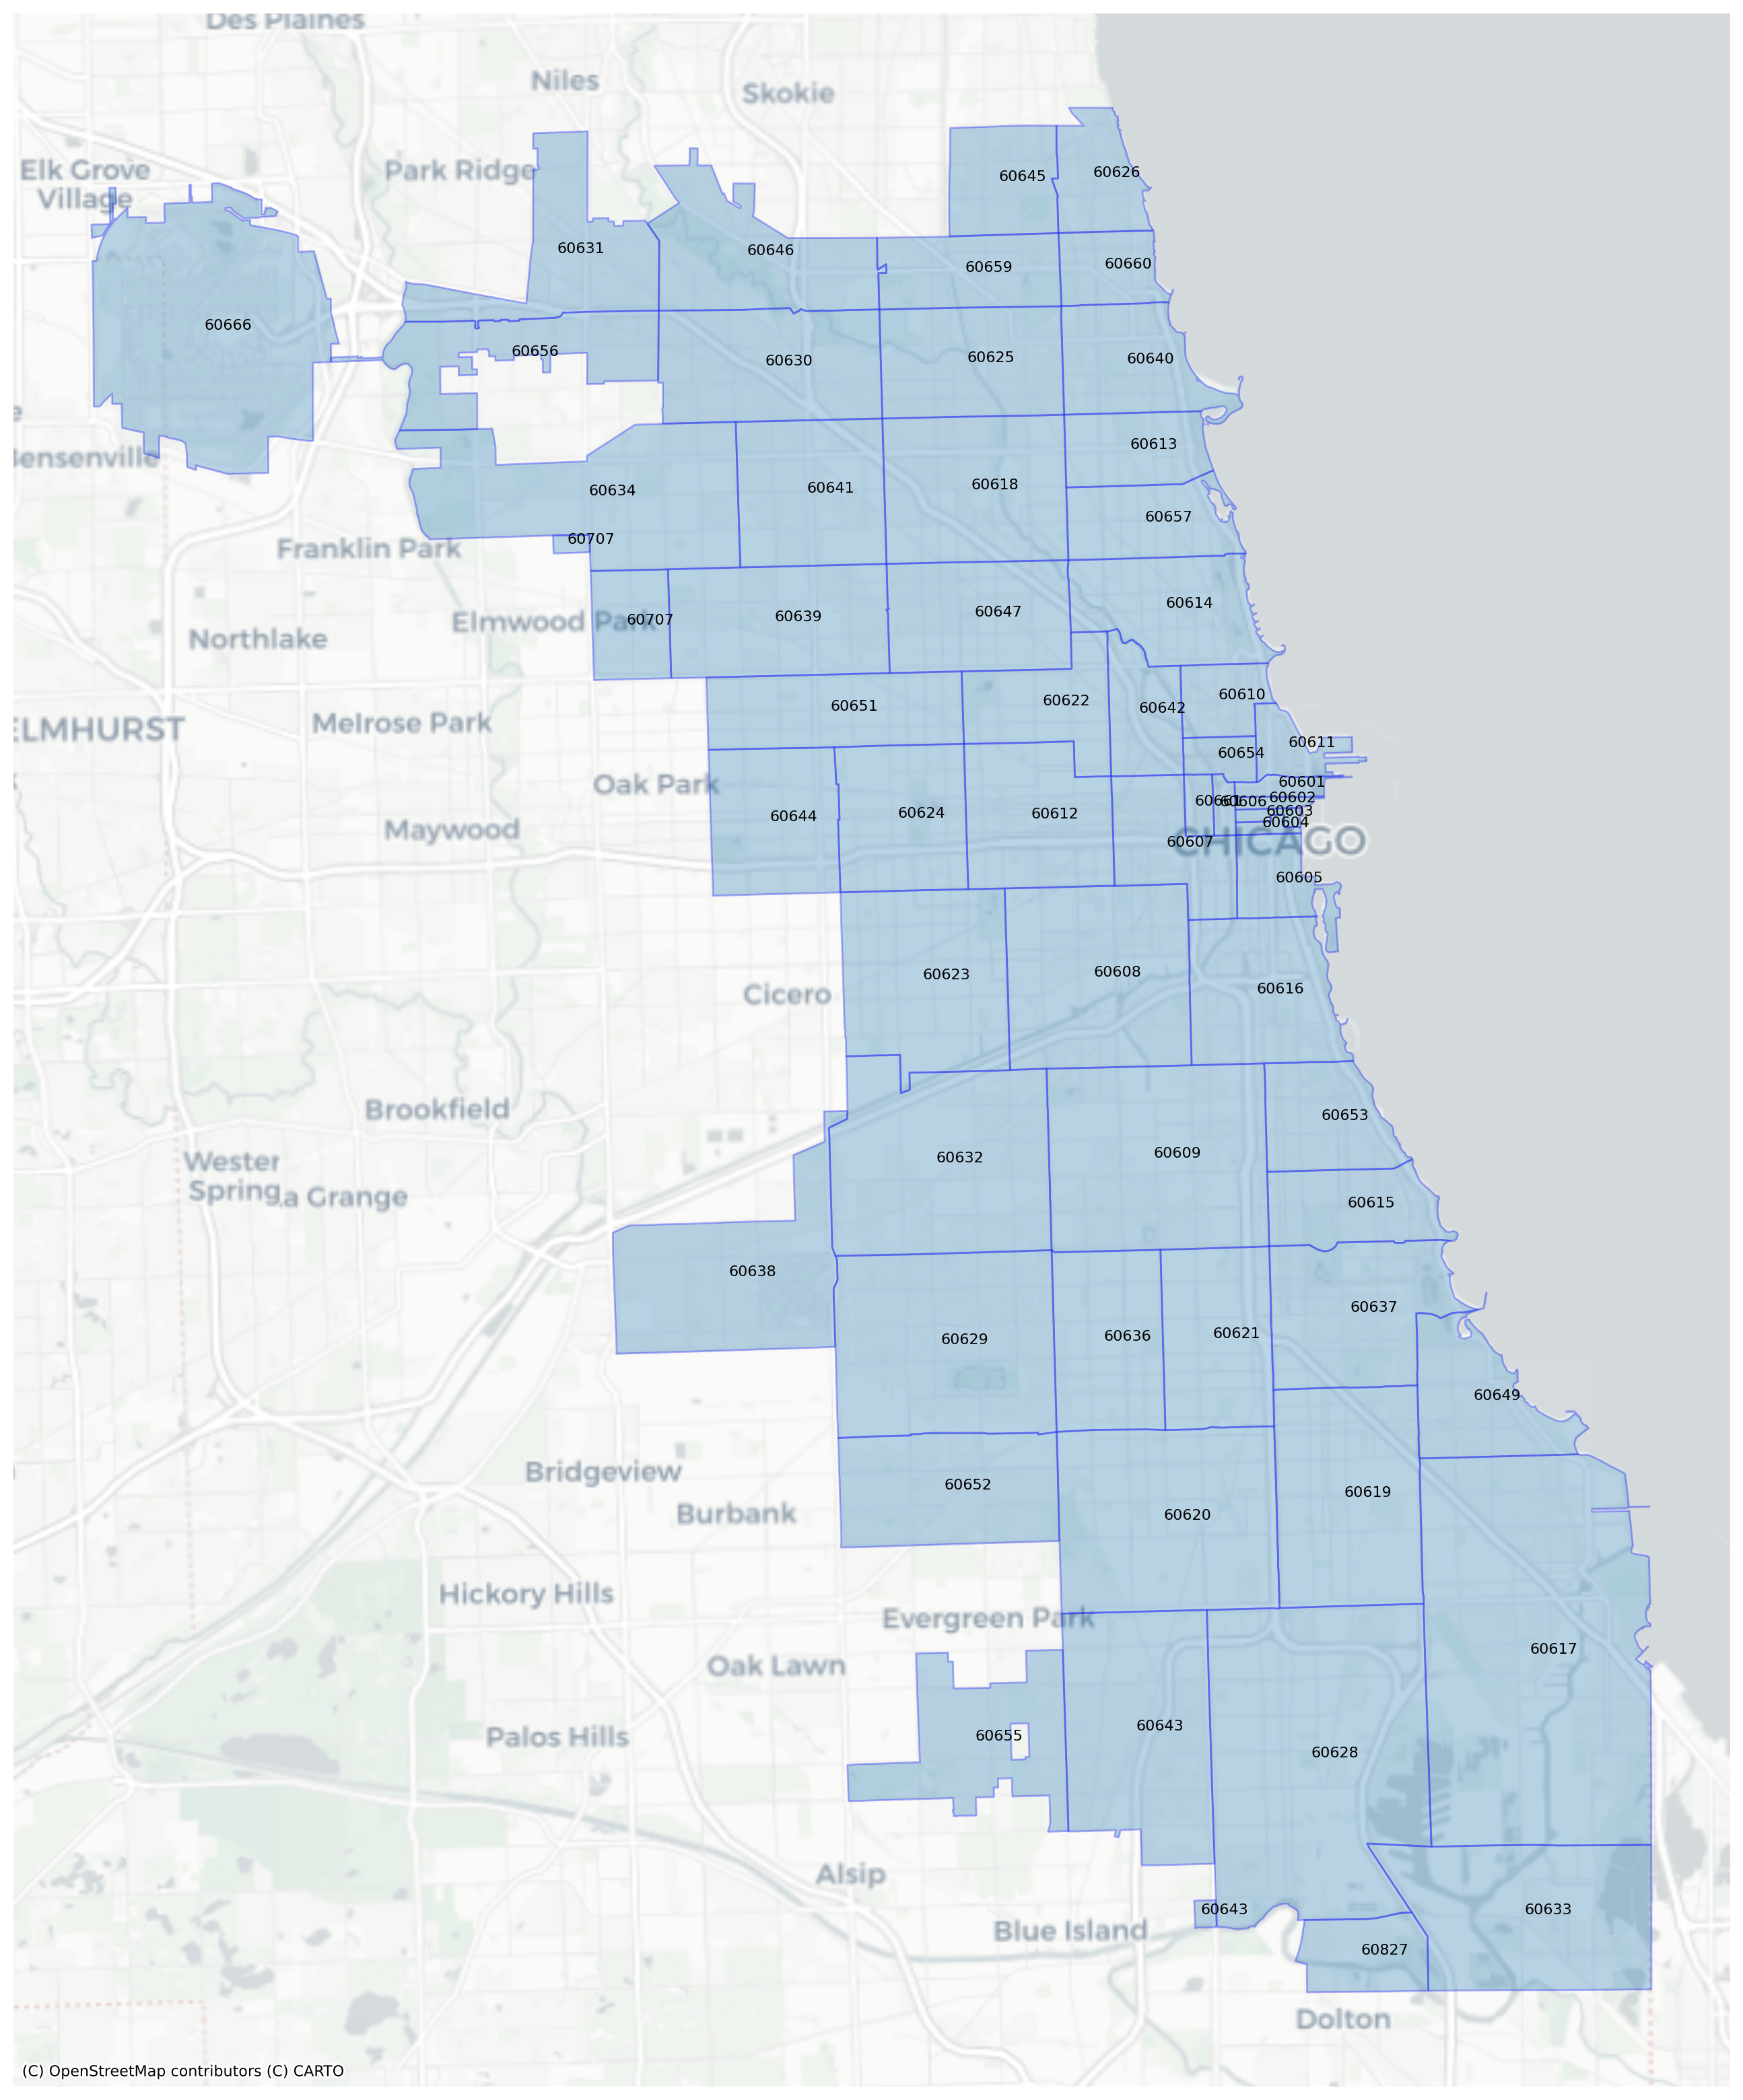

In [15]:
fig, ax = plt.subplots(figsize = (20,20), dpi = 200)


gdf.plot(ax = ax, alpha=0.3, edgecolor='b')

# show zipcodes
for idx, row in gdf.iterrows():
    plt.text(row.geometry.centroid.x-100, row.geometry.centroid.y, row['zip'], fontsize=8)

# add basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax.axis('off')

plt.show()

## Animation
### Base Image

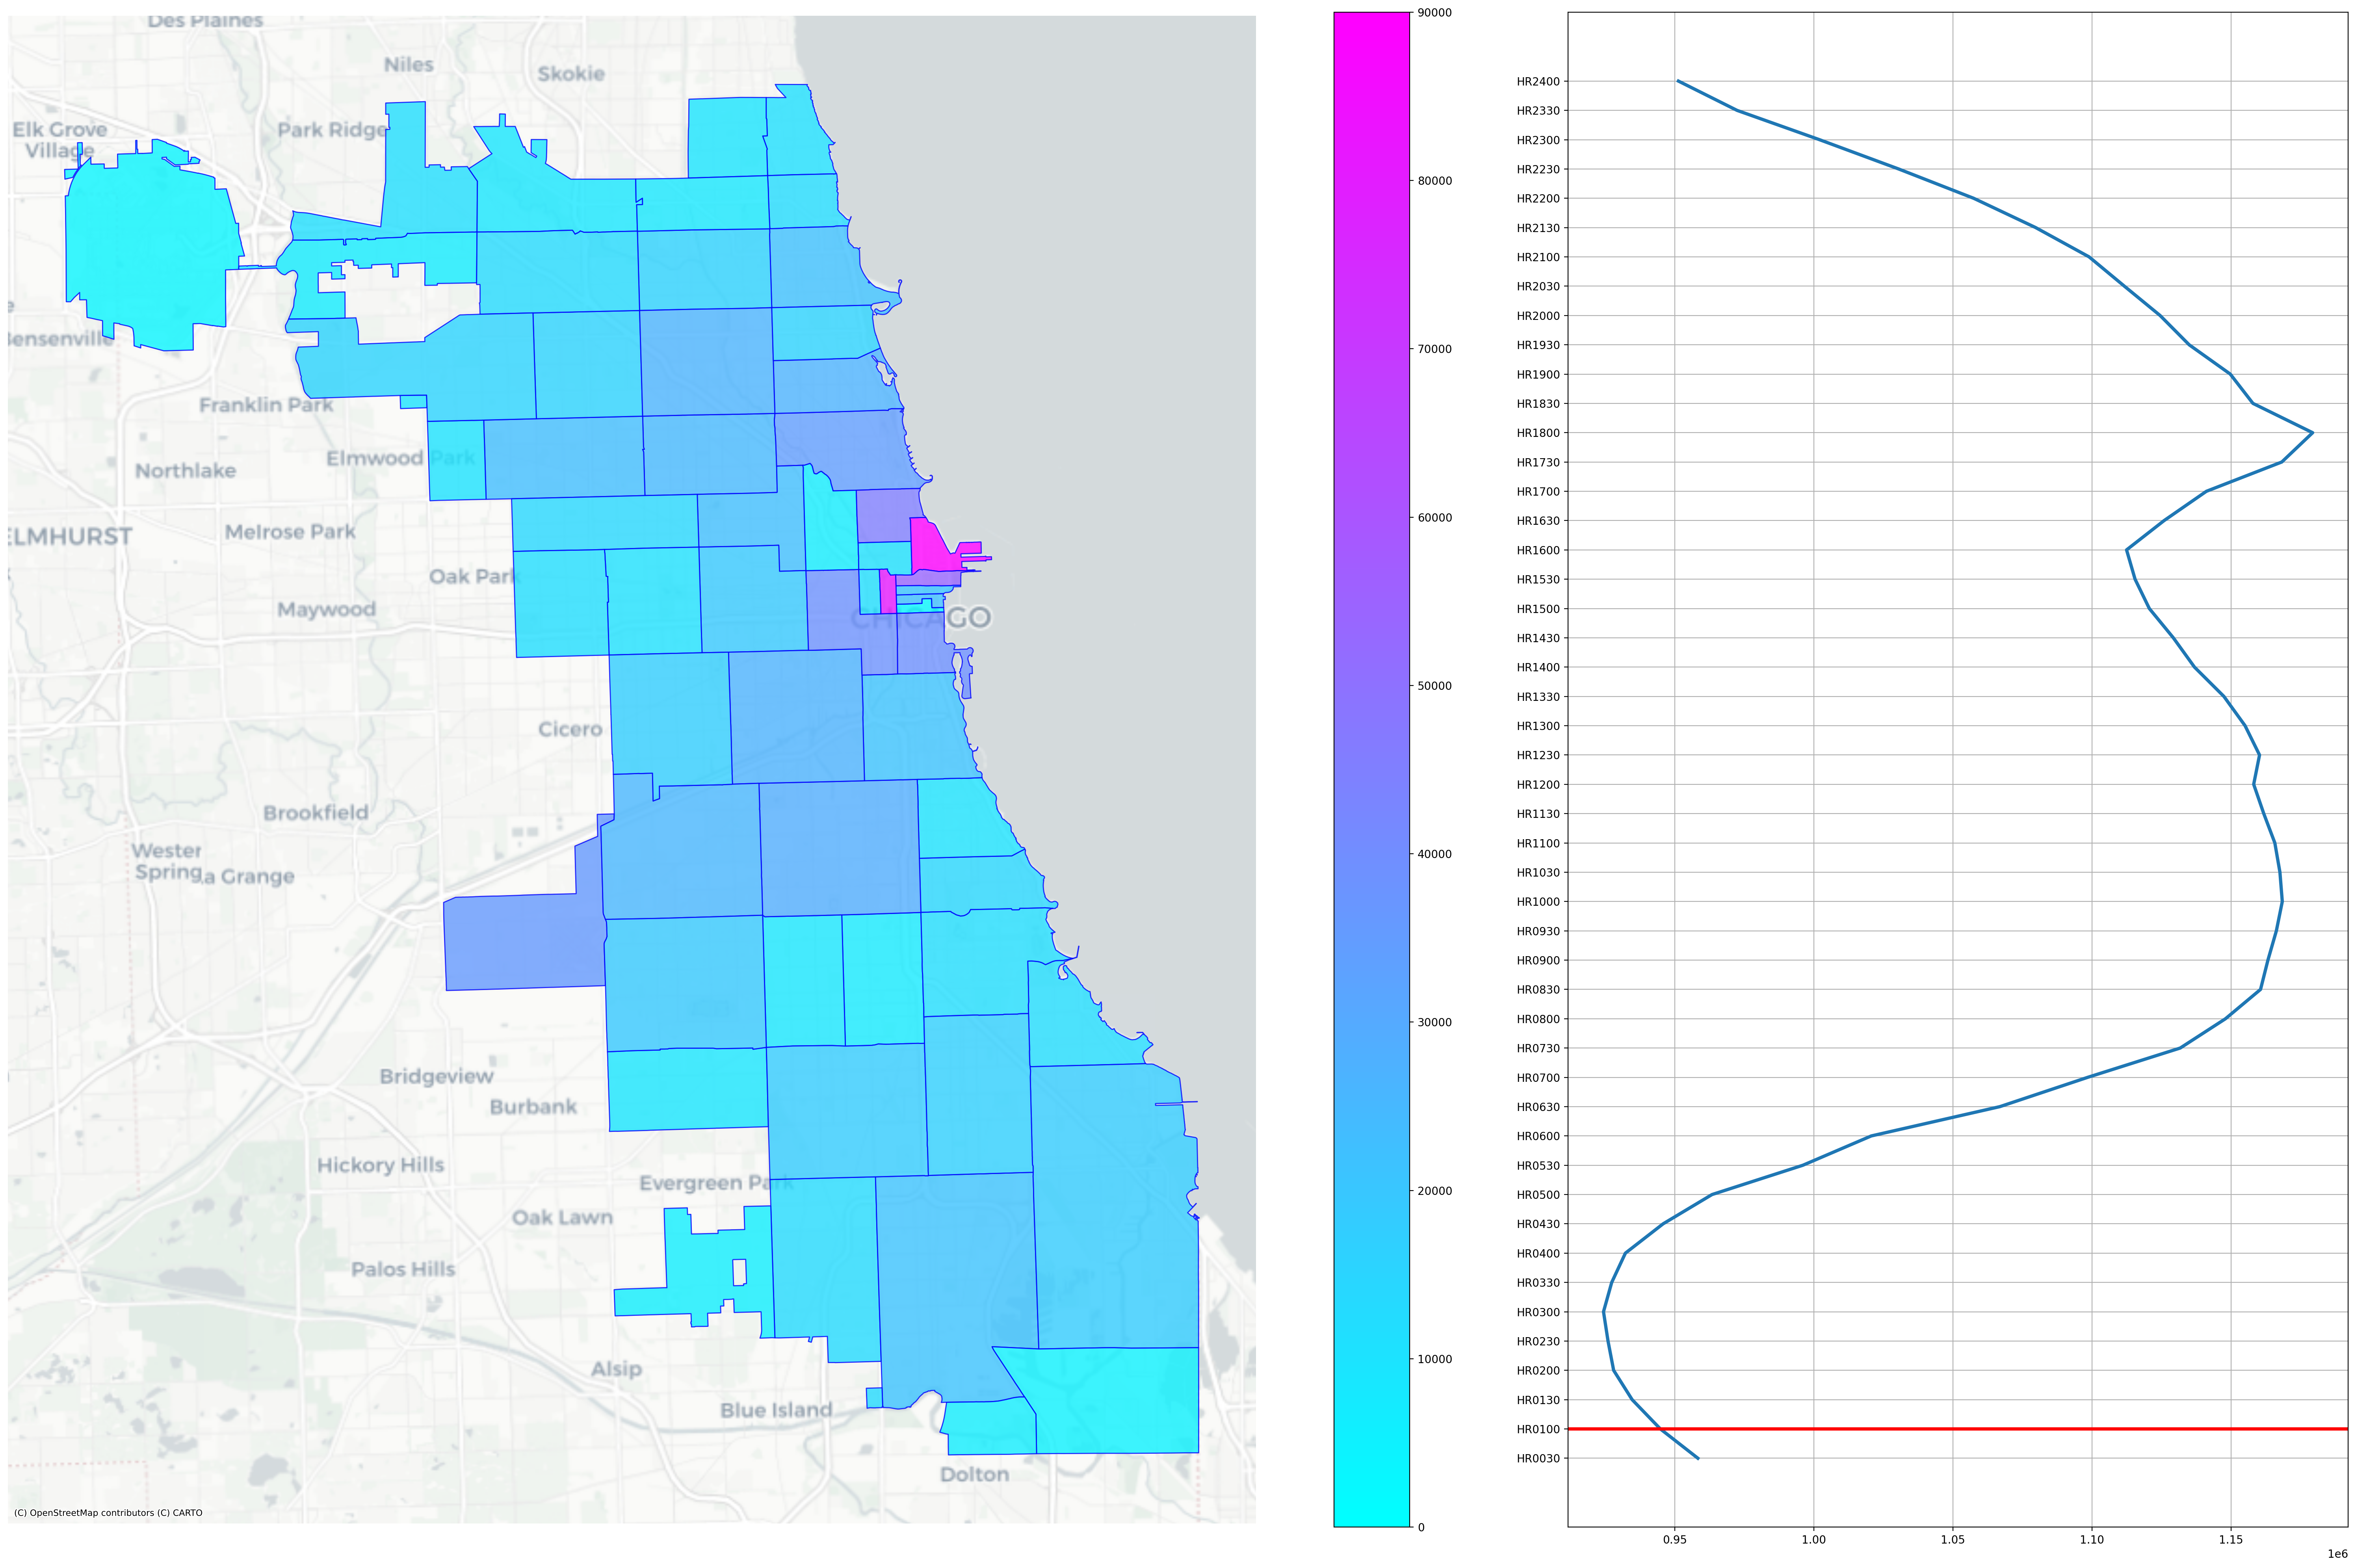

In [26]:
# Existing code for hr_sum and subplot creation
hr_columns = [col for col in df.columns if col.startswith('HR')]
hr_sum = df[hr_columns].sum()

# Create a subplot grid with 1 row and 2 columns
fig = plt.figure(figsize=(30, 20), dpi = 200)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # Set width ratio 2:1 for the subplots

# Define subplots within the grid
ax_map = plt.subplot(gs[0])
ax_right = plt.subplot(gs[1])

# merge on gdf
df['ZIP_CODE'] = df['ZIP_CODE'].astype(str)
gdf_time_series = gdf.merge(df, left_on='zip', right_on='ZIP_CODE', how='left').fillna(0)

min_value = 0
max_value = 90000

norm = mcolors.Normalize(min_value, max_value)

# Plot the map on the first subplot (ax_map)
gdf_time_series.plot(
    ax=ax_map,
    alpha=0.8,
    edgecolor='b',
    column = 'HR1000',
    legend = True,
    norm = norm,
    cmap = 'cool'
)

ctx.add_basemap(ax_map, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax_map.axis('off')

# Plot hr_sum with x and y axes swapped on the second subplot (ax_right)
ax_right.plot(hr_sum.values, hr_sum.index, linewidth = 3)
ax_right.axhline(1, color='r', linewidth=3)
ax_right.grid()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

## Create Frames

In [33]:
hours = list(gdf_time_series.columns)[9:]
min_value = 0
max_value = 90000

for i, hour in enumerate(hours):
    # Create a subplot grid with 1 row and 2 columns
    fig = plt.figure(figsize=(30, 20), dpi = 200)
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # Set width ratio 2:1 for the subplots

    # Define subplots within the grid
    ax_map = plt.subplot(gs[0])
    ax_right = plt.subplot(gs[1])

    # merge on gdf
    df['ZIP_CODE'] = df['ZIP_CODE'].astype(str)
    gdf_time_series = gdf.merge(df, left_on='zip', right_on='ZIP_CODE', how='left').fillna(0)

    norm = mcolors.Normalize(min_value, max_value)

    # Plot the map on the first subplot (ax_map)
    gdf_time_series.plot(
        ax=ax_map,
        alpha=1,
        edgecolor='b',
        column = hour,
        legend = True,
        norm = norm,
        cmap = 'viridis'
    )

    ctx.add_basemap(ax_map, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
    ax_map.axis('off')

    # Plot hr_sum with x and y axes swapped on the second subplot (ax_right)
    ax_right.plot(hr_sum.values, hr_sum.index, linewidth = 3)
    ax_right.axhline(i, color='r', linewidth=3)
    ax_right.grid()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    plt.savefig(f'./animation/viridis/anim_{hour}.png', dpi=200, bbox_inches='tight')
    plt.close()

## Create Gif

In [34]:
from PIL import Image
import os

# Directory containing the generated images
images_directory = './animation/viridis'

# Get a list of filenames of the images
image_files = sorted([os.path.join(images_directory, img) for img in os.listdir(images_directory) if img.endswith(".png")])

# Create a list to hold the images
frames = []
for filename in image_files:
    frames.append(Image.open(filename))

# Save the frames as an animated GIF
output_file = './animation/animation2.gif'
frames[0].save(output_file, format='GIF', append_images=frames[1:], save_all=True, duration=300, loop=5)  # Adjust duration (in milliseconds) as needed

print(f"Animation created at {output_file}")


Animation created at ./animation/animation2.gif
